In [46]:
import freetype
import numpy as np

face = freetype.Face("Arial.ttf")

face.set_pixel_sizes(0, 32) 

print(f"Family name: {face.family_name}")
print(f"Style name: {face.style_name}")
print(f"Number of glyphs: {face.num_glyphs}")

Family name: b'Arial'
Style name: b'Regular'
Number of glyphs: 1320


In [47]:
face.load_char('S', freetype.FT_LOAD_NO_BITMAP)
outline = face.glyph.outline

print(f"Character: 'S'")
print(f"Number of contours: {len(outline.contours)}")
print(f"Number of points: {len(outline.points)}")

for i, point in enumerate(outline.points):
    x, y = point
    tag = outline.tags[i]
    on_curve = (tag & 1) != 0
    point_type = "ON" if on_curve else "OFF (control point)"
    print(f"Point {i}: ({x}, {y}) - {point_type}")

for i, contour_end in enumerate(outline.contours):
    print(f"Contour {i} ends at point {contour_end}")

Character: 'S'
Number of contours: 1
Number of points: 49
Point 0: (92, 512) - ON
Point 1: (275, 512) - ON
Point 2: (288, 408) - OFF (control point)
Point 3: (383, 274) - OFF (control point)
Point 4: (583, 192) - OFF (control point)
Point 5: (708, 192) - ON
Point 6: (819, 192) - OFF (control point)
Point 7: (989, 254) - OFF (control point)
Point 8: (1072, 363) - OFF (control point)
Point 9: (1072, 425) - ON
Point 10: (1072, 489) - OFF (control point)
Point 11: (992, 583) - OFF (control point)
Point 12: (900, 616) - ON
Point 13: (841, 637) - OFF (control point)
Point 14: (437, 727) - OFF (control point)
Point 15: (356, 769) - ON
Point 16: (251, 822) - OFF (control point)
Point 17: (148, 981) - OFF (control point)
Point 18: (148, 1079) - ON
Point 19: (148, 1187) - OFF (control point)
Point 20: (274, 1375) - OFF (control point)
Point 21: (516, 1472) - OFF (control point)
Point 22: (664, 1472) - ON
Point 23: (827, 1472) - OFF (control point)
Point 24: (1076, 1365) - OFF (control point)
Poi

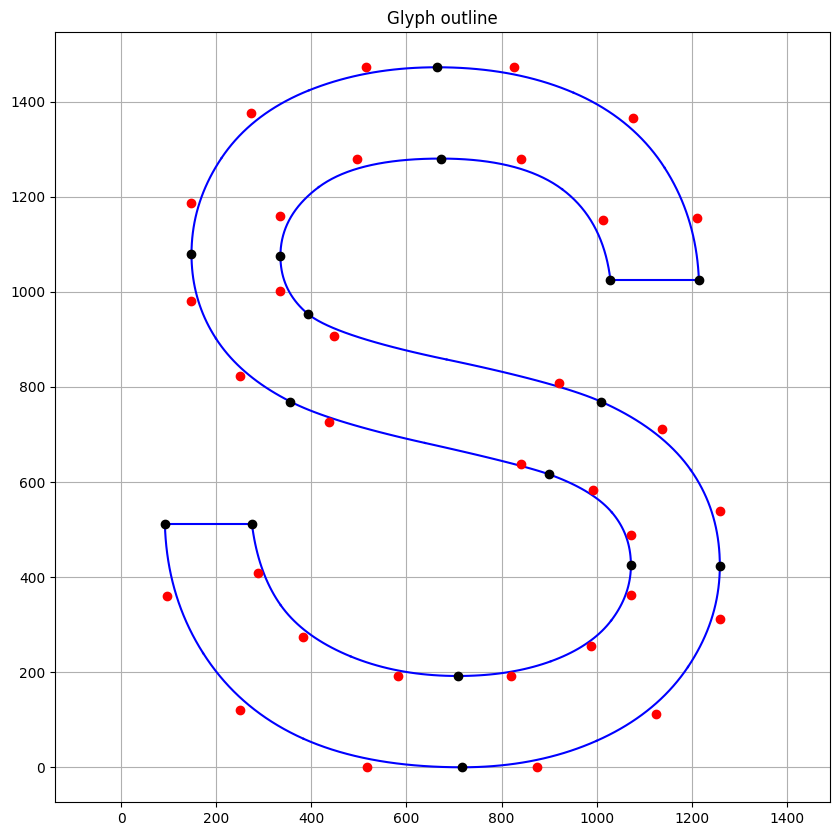

In [48]:
import numpy as np
import matplotlib.pyplot as plt


def extract_bezier_paths(outline):
    paths = []
    start = 0

    for end in outline.contours:
        points = outline.points[start:end + 1]
        tags = outline.tags[start:end + 1]

        # Ensure closed contour
        if np.any(points[0] != points[-1]):
            points = np.vstack([points, points[0]])
            tags = np.append(tags, tags[0])

        # Insert implicit on-curve points between consecutive off-curve points
        new_points = []
        new_tags = []

        for i in range(len(points)):
            curr = points[i]
            curr_tag = tags[i] & 1
            new_points.append(curr)
            new_tags.append(curr_tag)

            next_i = (i + 1) % len(points)
            next = points[next_i]
            next_tag = tags[next_i] & 1

            if not curr_tag and not next_tag:  # consecutive off-curve
                midpoint = (curr + next) / 2
                new_points.append(midpoint)
                new_tags.append(1)  # implicit on-curve

        points = new_points
        tags = new_tags

        # Start at first on-curve point
        i = 0
        while i < len(points) and not tags[i]:
            i += 1
        if i == len(points):  # all off-curve (degenerate case, but handle it)
            i = 0

        reordered_points = points[i:] + points[:i]
        reordered_tags = tags[i:] + tags[:i]

        # Close the loop
        reordered_points.append(reordered_points[0])
        reordered_tags.append(reordered_tags[0])

        segments = []
        idx = 0
        while idx < len(reordered_points) - 1:
            p0 = reordered_points[idx]
            t0 = reordered_tags[idx]
            p1 = reordered_points[idx + 1]
            t1 = reordered_tags[idx + 1]

            if t0 and t1:
                segments.append(('LINE', p0, p1))
                idx += 1
            elif t0 and not t1:
                p2 = reordered_points[idx + 2]
                segments.append(('BEZIER', p0, [p1], p2))
                idx += 2
            else:
                raise ValueError("Unexpected off-curve point without preceding on-curve")

        paths.append(segments)
        start = end + 1

    return paths


def evaluate_quadratic_bezier(p0, p1, p2, t):
    return (1-t)**2 * p0 + 2*(1-t)*t * p1 + t**2 * p2

def plot_glyph(outline, bezier_samples=20):
    paths = extract_bezier_paths(outline)
    
    plt.figure(figsize=(10, 10))
    
    colors = ['blue', 'green', 'purple', 'orange', 'cyan']
    
    for path_idx, segments in enumerate(paths):
        path_color = colors[path_idx % len(colors)]
        
        for segment_type, *data in segments:
            if segment_type == 'LINE':
                p0, p1 = data
                plt.plot([p0[0], p1[0]], [p0[1], p1[1]], color=path_color)
            elif segment_type == 'BEZIER':
                p0, control_points, p2 = data
                for p1 in control_points:
                    t_values = np.linspace(0, 1, bezier_samples)
                    curve_points = np.array([evaluate_quadratic_bezier(p0, p1, p2, t) for t in t_values])
                    plt.plot(curve_points[:, 0], curve_points[:, 1], color=path_color)
    
    
    for i, (point, tag) in enumerate(zip(outline.points, outline.tags)):
        if tag & 1:  
            plt.plot(point[0], point[1], 'ko')
        else: 
            plt.plot(point[0], point[1], 'ro')
    
    plt.gca()
    plt.axis('equal')
    plt.grid(True)
    plt.title(f"Glyph outline")
    
    return plt

face.load_char('S', freetype.FT_LOAD_NO_BITMAP)
outline = face.glyph.outline
plot_glyph(outline)
plt.show()

Rendering 'A'...
[Timing] extract_bezier_paths: 0.0003s
[Timing] edge generation:     0.0004s
[Timing] bbox & scale setup:  0.0001s
[Timing] scanline fill:       0.0195s
[Timing] gaussian blur:       0.0145s
[Timing] downsampling:        0.0025s
[Timing] TOTAL TIME:          0.0378s

Rendering 'B'...
[Timing] extract_bezier_paths: 0.0002s
[Timing] edge generation:     0.0025s
[Timing] bbox & scale setup:  0.0005s
[Timing] scanline fill:       0.1289s
[Timing] gaussian blur:       0.0141s
[Timing] downsampling:        0.0024s
[Timing] TOTAL TIME:          0.1493s

Rendering 'C'...
[Timing] extract_bezier_paths: 0.0002s
[Timing] edge generation:     0.0018s
[Timing] bbox & scale setup:  0.0003s
[Timing] scanline fill:       0.1045s
[Timing] gaussian blur:       0.0147s
[Timing] downsampling:        0.0024s
[Timing] TOTAL TIME:          0.1247s

Rendering 'D'...
[Timing] extract_bezier_paths: 0.0001s
[Timing] edge generation:     0.0014s
[Timing] bbox & scale setup:  0.0003s
[Timing] scan

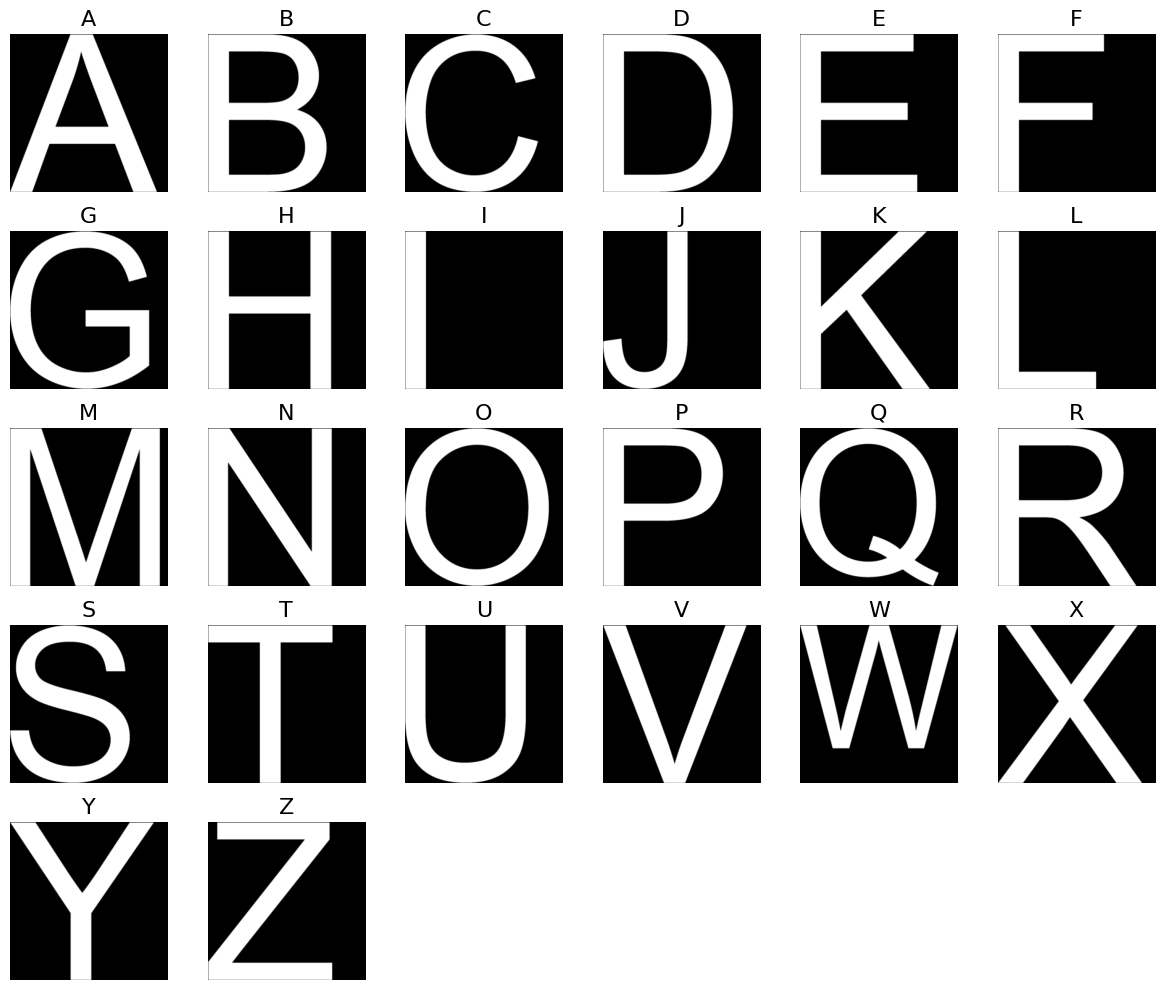

In [60]:
import time
from scipy.ndimage import gaussian_filter

def rasterize_glyph(outline, width, height, scale=1.0, supersample=4, blur_sigma=1.0):
    start_total = time.time()
    high_res_w = width * supersample
    high_res_h = height * supersample
    bitmap_high_res = np.zeros((high_res_h, high_res_w), dtype=np.float32)

    # Extract paths
    t0 = time.time()
    paths = extract_bezier_paths(outline)
    t1 = time.time()
    print(f"[Timing] extract_bezier_paths: {t1 - t0:.4f}s")

    # Generate polyline edges
    t0 = time.time()
    edges = []
    for segments in paths:
        polyline_points = []
        for segment_type, *data in segments:
            if segment_type == 'LINE':
                p0, p1 = data
                polyline_points.append(p0)
            elif segment_type == 'BEZIER':
                p0, control_points, p2 = data
                polyline_points.append(p0)
                for p1 in control_points:
                    t_values = np.linspace(0, 1, 20)[1:]
                    curve_points = np.array([evaluate_quadratic_bezier(p0, p1, p2, t) for t in t_values])
                    polyline_points.extend(curve_points)
        for i in range(len(polyline_points) - 1):
            edges.append((polyline_points[i], polyline_points[i+1]))
    t1 = time.time()
    print(f"[Timing] edge generation:     {t1 - t0:.4f}s")

    # Bounding box and scale
    t0 = time.time()
    glyph_min_x = min(min(p[0] for p, _ in edges), min(p[0] for _, p in edges))
    glyph_max_x = max(max(p[0] for p, _ in edges), max(p[0] for _, p in edges))
    glyph_min_y = min(min(p[1] for p, _ in edges), min(p[1] for _, p in edges))
    glyph_max_y = max(max(p[1] for p, _ in edges), max(p[1] for _, p in edges))

    glyph_width = glyph_max_x - glyph_min_x
    glyph_height = glyph_max_y - glyph_min_y

    scale_x = (high_res_w - 4) / glyph_width * scale
    scale_y = (high_res_h - 4) / glyph_height * scale
    scale_factor = min(scale_x, scale_y)
    t1 = time.time()
    print(f"[Timing] bbox & scale setup:  {t1 - t0:.4f}s")

    # Scanline fill
    t0 = time.time()
    for y in range(high_res_h):
        font_y = glyph_max_y - (y / scale_factor - 2 / scale_factor)
        intersections = []
        for (p0, p1) in edges:
            if (p0[1] <= font_y < p1[1]) or (p1[1] <= font_y < p0[1]):
                if p1[1] - p0[1] != 0:
                    x = p0[0] + (p1[0] - p0[0]) * (font_y - p0[1]) / (p1[1] - p0[1])
                    scaled_x = int((x - glyph_min_x) * scale_factor + 2)
                    if 0 <= scaled_x < high_res_w:
                        intersections.append(scaled_x)

        intersections.sort()
        for i in range(0, len(intersections), 2):
            if i + 1 < len(intersections):
                start = max(0, intersections[i])
                end = min(high_res_w, intersections[i + 1])
                bitmap_high_res[y, start:end] = 1.0
    t1 = time.time()
    print(f"[Timing] scanline fill:       {t1 - t0:.4f}s")

    # Blur
    t0 = time.time()
    blurred = gaussian_filter(bitmap_high_res, sigma=blur_sigma)
    t1 = time.time()
    print(f"[Timing] gaussian blur:       {t1 - t0:.4f}s")

    # Downsample
    t0 = time.time()
    bitmap = blurred.reshape(height, supersample, width, supersample).mean(axis=(1, 3))
    bitmap = (bitmap * 255).clip(0, 255).astype(np.uint8)
    t1 = time.time()
    print(f"[Timing] downsampling:        {t1 - t0:.4f}s")

    total = time.time() - start_total
    print(f"[Timing] TOTAL TIME:          {total:.4f}s\n")

    return bitmap

import string
import matplotlib.pyplot as plt
import freetype

# Load font
face = freetype.Face("Arial.ttf")
face.set_char_size(64*64)

# Grid config
n_cols = 6
n_rows = 5
glyph_w, glyph_h = 256, 256  # rasterized resolution

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))
alphabet = string.ascii_uppercase

for idx, char in enumerate(alphabet):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    face.load_char(char, freetype.FT_LOAD_NO_BITMAP)
    outline = face.glyph.outline
    print(f"Rendering '{char}'...")
    bitmap = rasterize_glyph(outline, glyph_w, glyph_h)

    ax.imshow(bitmap, cmap='gray')
    ax.axis('off')
    ax.set_title(char, fontsize=16)

# Hide any unused axes
for i in range(len(alphabet), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


[Timing] extract_bezier_paths: 0.0010s
[Timing] edge generation:     0.0036s
[Timing] bbox & scale setup:  0.0003s
[Timing] scanline fill:       0.0451s
[Timing] gaussian blur:       0.0058s
[Timing] downsampling:        0.0010s
[Timing] TOTAL TIME:          0.0574s

[Timing] extract_bezier_paths: 0.0001s
[Timing] edge generation:     0.0027s
[Timing] bbox & scale setup:  0.0005s
[Timing] scanline fill:       0.0778s
[Timing] gaussian blur:       0.0035s
[Timing] downsampling:        0.0006s
[Timing] TOTAL TIME:          0.0855s

[Timing] extract_bezier_paths: 0.0001s
[Timing] edge generation:     0.0004s
[Timing] bbox & scale setup:  0.0001s
[Timing] scanline fill:       0.0115s
[Timing] gaussian blur:       0.0033s
[Timing] downsampling:        0.0006s
[Timing] TOTAL TIME:          0.0161s

[Timing] extract_bezier_paths: 0.0003s
[Timing] edge generation:     0.0031s
[Timing] bbox & scale setup:  0.0005s
[Timing] scanline fill:       0.0855s
[Timing] gaussian blur:       0.0032s
[Timi

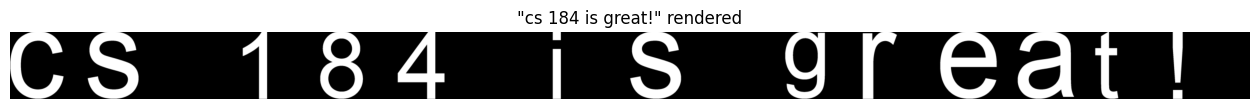

In [61]:
sentence = "cs 184 is great!"
glyph_w, glyph_h = 128, 128
spacing = 20  # pixels between characters

bitmaps = []

for char in sentence:
    if char == ' ':
        bitmap = np.zeros((glyph_h, glyph_w), dtype=np.uint8)  # space = blank image
    else:
        face.load_char(char, freetype.FT_LOAD_NO_BITMAP)
        outline = face.glyph.outline
        bitmap = rasterize_glyph(outline, glyph_w, glyph_h)
    bitmaps.append(bitmap)

# Combine into one canvas
total_width = len(bitmaps) * (glyph_w + spacing)
canvas = np.zeros((glyph_h, total_width), dtype=np.uint8)

x_offset = 0
for bmp in bitmaps:
    canvas[:, x_offset:x_offset + glyph_w] = bmp
    x_offset += glyph_w + spacing

# Show the sentence
plt.figure(figsize=(16, 4))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title(f'"{sentence}" rendered')
plt.show()
